In [59]:
import torch 
import logging
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch



def l_modularity_loss(assignments, events, degrees, mu):
    """
    L-Modularity loss with proper normalization.

    assignments: Tensor of shape (N, T, K)
        Soft community assignments h_u(t), sum to 1 over K.
    events: LongTensor of shape (E, 4)
        Each row [idx, i, j, t] is an event between i and j at time t.
    degrees: Tensor of shape (N,)
        Node degrees k_u over the entire link stream.
    m: float
        Total number of (undirected) events: m = |E|.
    mu: float
        Weight of the smoothness penalty.

    Returns:
        loss: Scalar Tensor = −Q_norm + mu * smoothness_norm,
              where Q_norm ∈ [−1,1] and smoothness_norm ∈ [0,1].
    """
    N, T, K = assignments.shape
    E = events.shape[0]

    # --- 1) Observed co-membership at each event ---
    i_idx, j_idx, t_idx = events[:,1], events[:,2], events[:,3]
    h_i = assignments[i_idx, t_idx]   # (E, K)
    h_j = assignments[j_idx, t_idx]   # (E, K)
    obs = (h_i * h_j).sum(dim=1)      # (E,)
    # Sum over all events, then normalize by 2m as in static modularity
    observed_sum = obs.sum() 

    # --- 2) Expected co-membership under longitudinal null model ---
    # Get degrees for each event
    deg_i = degrees[i_idx].float().to(assignments.device)
    deg_j = degrees[j_idx].float().to(assignments.device)
    # Per-event expected co-membership: (k_i k_j)/(2m) * avg_t [h_i(t)·h_j(t)]
    # First compute avg_t dot products over all T time points:
    h_i_all = assignments[i_idx]      # (E, T, K)
    h_j_all = assignments[j_idx]      # (E, T, K)
    dots = (h_i_all * h_j_all).sum(dim=2)  # (E, T)
    avg_dot = dots.mean(dim=1)            # (E,)
    expct = (deg_i * deg_j / (2 * E)) * avg_dot  # (E,)
    expected_sum = expct.sum()

    # --- 3) Normalized modularity score Q ∈ [−1,1] ---
    Q_norm = (observed_sum - expected_sum) / (2 * E)

    # --- 4) Smoothness penalty: squared L2 jumps between t and t+1 ---
    diffs = assignments[:, 1:, :] - assignments[:, :-1, :]  # (N, T-1, K)
    smooth = diffs.pow(2).sum()  # maximum is 2 * N * (T-1)
    # Normalize by the maximal possible jump sum
    smoothness_norm = smooth / (N * (T - 1))

    # --- 5) Final loss: minimize negative modularity + mu * smoothness ---
    loss = -Q_norm + mu * smoothness_norm
    return loss, Q_norm, smoothness_norm

In [60]:
N, T, K = 3, 2, 2

# Soft assignments 随机初始化并做归一化
torch.manual_seed(0)
raw = torch.rand(N, T, K)
assignments = raw / raw.sum(dim=2, keepdim=True)

# 4 条交互事件：(dummy_index, i, j, t)
# 这里 dummy_index 不影响计算，仅为兼容原数据格式
events = torch.tensor([
    [0, 0, 1, 0],
    [1, 1, 2, 0],
    [2, 0, 2, 1],
    [3, 1, 2, 1],
], dtype=torch.long)

# 度数 k_u：简单取每个节点参与事件次数
degrees = torch.tensor([2, 3, 3], dtype=torch.float)

# 事件总数 m (无向)：4
m = 4.0

# 平滑惩罚权重
mu = 1
print(assignments)
# 计算 loss
loss, Q, smoothness = l_modularity_loss(assignments, events, degrees, mu)
print(f"归一化后的 L-Modularity Loss = {loss.item():.6f}")
print(f"Q_norm = {Q.item():.6f}")
print(f"smoothness_norm = {smoothness.item():.6f}")

tensor([[[0.3925, 0.6075],
         [0.4012, 0.5988]],

        [[0.3265, 0.6735],
         [0.3535, 0.6465]],

        [[0.4188, 0.5812],
         [0.4648, 0.5352]]])
归一化后的 L-Modularity Loss = -0.014360
Q_norm = 0.016306
smoothness_norm = 0.001947


In [61]:
import torch
import torch.nn as nn

class MemoryModule(nn.Module):
    """
    A simplified TGN-style Memory module that:
    - Holds a per-node memory tensor of shape (num_nodes, memory_dim)
    - Updates memory via a GRUCell given aggregated messages per node
    """

    def __init__(self, num_nodes: int, memory_dim: int, msg_dim: int):
        super().__init__()
        self.num_nodes = num_nodes
        self.memory_dim = memory_dim
        
        # Initialize memory for all nodes (num_nodes x memory_dim)
        self.register_buffer('memory', torch.zeros(num_nodes, memory_dim))
        
        # Initialize last_update timestamps for all nodes (num_nodes,)
        self.register_buffer('last_update', torch.zeros(num_nodes, dtype=torch.long))
        
        # GRUCell for updating memory: input is msg_dim, hidden is memory_dim
        self.gru = nn.GRUCell(input_size=msg_dim, hidden_size=memory_dim)
        
    def forward(self, node_ids: torch.LongTensor, msgs: torch.Tensor, timestamps: torch.LongTensor):
        """
        Update memory for the given nodes based on their aggregated messages.
        
        Args:
            node_ids: LongTensor of shape (B,) with node indices in this batch.
            msgs: Tensor of shape (B, msg_dim) with aggregated message per node.
            timestamps: LongTensor of shape (B,) with event timestamps per message.
        """
        # Gather old memory for these nodes
        old_mem = self.memory[node_ids]           # (B, memory_dim)
        
        # Update memory via GRUCell
        new_mem = self.gru(msgs, old_mem)         # (B, memory_dim)
        
        # Write back updated memory
        self.memory[node_ids] = new_mem
        
        # Update last_update timestamps
        self.last_update[node_ids] = timestamps
        
        return new_mem

# Example usage:
num_nodes = 1000
memory_dim = 128
msg_dim = 64

memory_module = MemoryModule(num_nodes, memory_dim, msg_dim)

# Suppose batch of 3 nodes with aggregated messages and timestamps
batch_node_ids = torch.tensor([5, 20, 500])
aggregated_msgs = torch.randn(3, msg_dim)
batch_times = torch.tensor([100, 100, 100], dtype=torch.long)

# Forward pass updates memory in-place
updated_memory = memory_module(batch_node_ids, aggregated_msgs, batch_times)
print("Updated memory shape:", updated_memory.shape)

Updated memory shape: torch.Size([3, 128])


In [77]:
import torch 
import logging
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch


class MergeLayer(torch.nn.Module):
    def __init__(self, dim1, dim2, dim3, dim4):
        super().__init__()
        #self.layer_norm = torch.nn.LayerNorm(dim1 + dim2)
        self.fc1 = torch.nn.Linear(dim1 + dim2, dim3)
        self.fc2 = torch.nn.Linear(dim3, dim4)
        self.act = torch.nn.ReLU()
        torch.nn.init.xavier_normal_(self.fc1.weight)
        torch.nn.init.xavier_normal_(self.fc2.weight)

    def forward(self, x1, x2):
        x = torch.cat([x1, x2], dim=1)
        h = self.act(self.fc1(x))
        return self.fc2(h)


class CommunityLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_communities):
        super(CommunityLayer, self).__init__()
        self.num_communities = num_communities
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_communities)
        )

    def forward(self, node_features):
        """
        node_features: Tensor (batch_size, T, D)
        returns:
            logits: Tensor (batch_size, T, K)
            probs:  Tensor (batch_size, T, K)
        """
        B, T, D = node_features.size()
        feats_flat = node_features.view(B * T, D)
        logits_flat = self.mlp(feats_flat)
        probs_flat = F.softmax(logits_flat, dim=-1)
        logits = logits_flat.view(B, T, self.num_communities)
        probs  = probs_flat.view(B, T, self.num_communities)
        return logits, probs

    

class LSTMPool(torch.nn.Module):
    def __init__(self, feat_dim, time_dim):
        super(LSTMPool, self).__init__()
        self.feat_dim = feat_dim
        self.time_dim = time_dim
        self.att_dim = feat_dim + time_dim
        self.act = torch.nn.ReLU()
        self.lstm = torch.nn.LSTM(input_size=self.att_dim, 
                                  hidden_size=self.feat_dim, 
                                  num_layers=1, 
                                  batch_first=True)
        self.merger = MergeLayer(feat_dim, feat_dim, feat_dim, feat_dim)
    def forward(self, src, src_t, seq, seq_t, mask):
        # seq [B, N, D]
        # mask [B, N]
        seq_x = torch.cat([seq, seq_t], dim=2)
            
        _, (hn, _) = self.lstm(seq_x)
        
        hn = hn[-1, :, :] #hn.squeeze(dim=0)

        out = self.merger.forward(hn, src)
        return out, None


class MeanPool(torch.nn.Module):
    def __init__(self, feat_dim):
        super(MeanPool, self).__init__()
        self.feat_dim = feat_dim
        self.act = torch.nn.ReLU()
        self.merger = MergeLayer(feat_dim, feat_dim, feat_dim, feat_dim)
        
    def forward(self, src, seq, seq_e):
        # seq [B, N, D]
        # mask [B, N]
        src_x = src
        seq_x = torch.cat([seq, seq_e], dim=2) #[B, N, De + D]
        hn = seq_x.mean(dim=1) #[B, De + D]
        output = self.merger(hn, src_x)
        return output, None

class ScaledDotProductAttention(torch.nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = torch.nn.Dropout(attn_dropout)
        self.softmax = torch.nn.Softmax(dim=2)

    def forward(self, q, k, v, mask=None):

        attn = torch.bmm(q, k.transpose(1, 2))
        attn = attn / self.temperature

        if mask is not None:
            attn = attn.masked_fill(mask, -1e10)

        attn = self.softmax(attn) # [n * b, l_q, l_k]
        attn = self.dropout(attn) # [n * b, l_v, d]
                
        output = torch.bmm(attn, v)
        
        return output, attn

class MultiHeadAttention(nn.Module):
    ''' Multi-Head Attention module '''

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()

        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_ks = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_vs = nn.Linear(d_model, n_head * d_v, bias=False)
        nn.init.normal_(self.w_qs.weight, mean=0, std=np.sqrt(2.0 / (d_model + d_k)))
        nn.init.normal_(self.w_ks.weight, mean=0, std=np.sqrt(2.0 / (d_model + d_k)))
        nn.init.normal_(self.w_vs.weight, mean=0, std=np.sqrt(2.0 / (d_model + d_v)))

        self.attention = ScaledDotProductAttention(temperature=np.power(d_k, 0.5), attn_dropout=dropout)
        self.layer_norm = nn.LayerNorm(d_model)

        self.fc = nn.Linear(n_head * d_v, d_model)
        
        nn.init.xavier_normal_(self.fc.weight)

        self.dropout = nn.Dropout(dropout)


    def forward(self, q, k, v, mask=None):

        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head

        sz_b, len_q, _ = q.size()
        sz_b, len_k, _ = k.size()
        sz_b, len_v, _ = v.size()

        residual = q

        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)

        q = q.permute(2, 0, 1, 3).contiguous().view(-1, len_q, d_k) # (n*b) x lq x dk
        k = k.permute(2, 0, 1, 3).contiguous().view(-1, len_k, d_k) # (n*b) x lk x dk
        v = v.permute(2, 0, 1, 3).contiguous().view(-1, len_v, d_v) # (n*b) x lv x dv

        mask = mask.repeat(n_head, 1, 1) # (n*b) x .. x ..
        output, attn = self.attention(q, k, v, mask=mask)

        output = output.view(n_head, sz_b, len_q, d_v)
        
        output = output.permute(1, 2, 0, 3).contiguous().view(sz_b, len_q, -1) # b x lq x (n*dv)

        output = self.dropout(self.fc(output))
        output = self.layer_norm(output + residual)
        #output = self.layer_norm(output)
        
        return output, attn
    

class MapBasedMultiHeadAttention(nn.Module):
    ''' Multi-Head Attention module '''
    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()

        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        self.wq_node_transform = nn.Linear(d_model, n_head * d_k, bias=False)
        self.wk_node_transform = nn.Linear(d_model, n_head * d_k, bias=False)
        self.wv_node_transform = nn.Linear(d_model, n_head * d_k, bias=False)
        
        self.layer_norm = nn.LayerNorm(d_model)

        self.fc = nn.Linear(n_head * d_v, d_model)
        
        self.act = nn.LeakyReLU(negative_slope=0.2)
        self.weight_map = nn.Linear(2 * d_k, 1, bias=False)
        
        nn.init.xavier_normal_(self.fc.weight)
        
        self.dropout = torch.nn.Dropout(dropout)
        self.softmax = torch.nn.Softmax(dim=2)

        self.dropout = nn.Dropout(dropout)


    def forward(self, q, k, v, mask=None):
        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        sz_b, len_q, _ = q.size()
        sz_b, len_k, _ = k.size()
        sz_b, len_v, _ = v.size()

        residual = q

        q = self.wq_node_transform(q).view(sz_b, len_q, n_head, d_k)
        
        k = self.wk_node_transform(k).view(sz_b, len_k, n_head, d_k)
        
        v = self.wv_node_transform(v).view(sz_b, len_v, n_head, d_v)

        q = q.permute(2, 0, 1, 3).contiguous().view(-1, len_q, d_k) # (n*b) x lq x dk
        q = torch.unsqueeze(q, dim=2) # [(n*b), lq, 1, dk]
        q = q.expand(q.shape[0], q.shape[1], len_k, q.shape[3]) # [(n*b), lq, lk, dk]
        
        k = k.permute(2, 0, 1, 3).contiguous().view(-1, len_k, d_k) # (n*b) x lk x dk
        k = torch.unsqueeze(k, dim=1) # [(n*b), 1, lk, dk]
        k = k.expand(k.shape[0], len_q, k.shape[2], k.shape[3]) # [(n*b), lq, lk, dk]
        
        v = v.permute(2, 0, 1, 3).contiguous().view(-1, len_v, d_v) # (n*b) x lv x dv
        
        mask = mask.repeat(n_head, 1, 1) # (n*b) x lq x lk
        
        ## Map based Attention
        #output, attn = self.attention(q, k, v, mask=mask)
        q_k = torch.cat([q, k], dim=3) # [(n*b), lq, lk, dk * 2]
        attn = self.weight_map(q_k).squeeze(dim=3) # [(n*b), lq, lk]
        
        if mask is not None:
            attn = attn.masked_fill(mask, -1e10)

        attn = self.softmax(attn) # [n * b, l_q, l_k]
        attn = self.dropout(attn) # [n * b, l_q, l_k]
        
        # [n * b, l_q, l_k] * [n * b, l_v, d_v] >> [n * b, l_q, d_v]
        output = torch.bmm(attn, v)
        output = output.view(n_head, sz_b, len_q, d_v)
        output = output.permute(1, 2, 0, 3).contiguous().view(sz_b, len_q, -1) # b x lq x (n*dv)
        output = self.dropout(self.act(self.fc(output)))
        output = self.layer_norm(output + residual)
        return output, attn
    
def expand_last_dim(x, num):
    view_size = list(x.size()) + [1]
    expand_size = list(x.size()) + [num]
    return x.view(view_size).expand(expand_size)


class AttnModel(torch.nn.Module):
    """Attention based temporal layers
    """
    def __init__(self, feat_dim, time_dim, 
                 attn_mode='prod', n_head=2, drop_out=0.1):
        """
        args:
          feat_dim: dim for the node features
          edge_dim: dim for the temporal edge features
          time_dim: dim for the time encoding
          attn_mode: choose from 'prod' and 'map'
          n_head: number of heads in attention
          drop_out: probability of dropping a neural.
        """
        super(AttnModel, self).__init__()
        
        self.feat_dim = feat_dim
        self.time_dim = time_dim
        
        self.edge_in_dim = (feat_dim + time_dim)
        self.model_dim = self.edge_in_dim
        #self.edge_fc = torch.nn.Linear(self.edge_in_dim, self.feat_dim, bias=False)

        self.merger = MergeLayer(self.model_dim, feat_dim, feat_dim, feat_dim)

        #self.act = torch.nn.ReLU()
        
        assert(self.model_dim % n_head == 0)
        self.logger = logging.getLogger(__name__)
        self.attn_mode = attn_mode
        
        if attn_mode == 'prod':
            self.multi_head_target = MultiHeadAttention(n_head, 
                                             d_model=self.model_dim, 
                                             d_k=self.model_dim // n_head, 
                                             d_v=self.model_dim // n_head, 
                                             dropout=drop_out)
            self.logger.info('Using scaled prod attention')
            
        elif attn_mode == 'map':
            self.multi_head_target = MapBasedMultiHeadAttention(n_head, 
                                             d_model=self.model_dim, 
                                             d_k=self.model_dim // n_head, 
                                             d_v=self.model_dim // n_head, 
                                             dropout=drop_out)
            self.logger.info('Using map based attention')
        else:
            raise ValueError('attn_mode can only be prod or map')
        
        
    def forward(self, src, src_t, seq, seq_t, seq_e, mask):
        """"Attention based temporal attention forward pass
        args:
          src: float Tensor of shape [B, D]
          src_t: float Tensor of shape [B, Dt], Dt == D
          seq: float Tensor of shape [B, N, D]
          seq_t: float Tensor of shape [B, N, Dt]
          seq_e: float Tensor of shape [B, N, De], De == D
          mask: boolean Tensor of shape [B, N], where the true value indicate a null value in the sequence.

        returns:
          output, weight

          output: float Tensor of shape [B, D]
          weight: float Tensor of shape [B, N]
        """

        src_ext = torch.unsqueeze(src, dim=1) # src [B, 1, D]
        src_e_ph = torch.zeros_like(src_ext)
        q = torch.cat([src_ext, src_e_ph, src_t], dim=2) # [B, 1, D + De + Dt] -> [B, 1, D]
        k = torch.cat([seq, seq_e, seq_t], dim=2) # [B, 1, D + De + Dt] -> [B, 1, D]
        
        mask = torch.unsqueeze(mask, dim=2) # mask [B, N, 1]
        mask = mask.permute([0, 2, 1]) #mask [B, 1, N]

        # # target-attention
        output, attn = self.multi_head_target(q=q, k=k, v=k, mask=mask) # output: [B, 1, D + Dt], attn: [B, 1, N]
        output = output.squeeze()
        attn = attn.squeeze()

        output = self.merger(output, src)
        return output, attn
    
class TimeEncode(torch.nn.Module):
    def __init__(self, expand_dim, factor=5):
        super(TimeEncode, self).__init__()
        time_dim = expand_dim
        self.factor = factor
        self.basis_freq = torch.nn.Parameter((torch.from_numpy(1 / 10 ** np.linspace(0, 9, time_dim))).float())
        self.phase = torch.nn.Parameter(torch.zeros(time_dim).float())
        
    def forward(self, ts):
        # ts: [N, L]
        batch_size = ts.size(0)
        seq_len = ts.size(1)
        ts = ts.view(batch_size, seq_len, 1)# [N, L, 1]
        map_ts = ts * self.basis_freq.view(1, 1, -1) # [N, L, time_dim]
        map_ts += self.phase.view(1, 1, -1)
        harmonic = torch.cos(map_ts)
        return harmonic #self.dense(harmonic)
    

class GT(torch.nn.Module):
    def __init__(self, ngh_finder, n_feat, num_communities=10, agg_method='lstm', node_dim=None, time_dim=None,
                 num_layers=3, null_idx=0, drop_out=0.1, memory_dim=128, msg_dim=128, seq_len=None):
        super(GT, self).__init__()

        self.num_layers = num_layers 
        self.ngh_finder = ngh_finder
        self.null_idx = null_idx
        self.logger = logging.getLogger(__name__)
        self.n_feat_th = torch.nn.Parameter(torch.from_numpy(n_feat.astype(np.float32)))

        self.node_raw_embed = torch.nn.Embedding.from_pretrained(self.n_feat_th, padding_idx=0, freeze=True)

        self.feat_dim = self.n_feat_th.shape[1]
        self.n_feat_dim = self.feat_dim
        self.model_dim = self.feat_dim
        self.merge_layer = MergeLayer(self.feat_dim, self.feat_dim, self.feat_dim, self.feat_dim)
        self.num_communities = num_communities
        self.community_layer = CommunityLayer(input_dim=self.feat_dim,  # 输入维度为节点嵌入的维度
            hidden_dim=self.feat_dim,  # 隐藏层维度与特征维度相同
            num_communities=self.num_communities  # 社区数量
        )
        if msg_dim is not None:
            msg_dim = self.feat_dim
        num_nodes = self.n_feat_th.shape[0]
        self.memory_module = MemoryModule(num_nodes, memory_dim, msg_dim)

        if agg_method == 'attn':
            self.logger.info('Aggregation uses attention model')
            self.attn_model_list = torch.nn.ModuleList([AttnModel(self.feat_dim, 
                                                               self.feat_dim, 
                                                               self.feat_dim,
                                                               attn_mode='prod', 
                                                               n_head=4, 
                                                               drop_out=drop_out) for _ in range(num_layers)])
        elif agg_method == 'lstm':
            self.attn_model_list = torch.nn.ModuleList([LSTMPool(self.feat_dim, self.feat_dim) for _ in range(num_layers)])
        elif agg_method == 'mean':
            self.attn_model_list = torch.nn.ModuleList([MeanPool(self.feat_dim) for _ in range(num_layers)])
        else:
            raise ValueError('invalid agg_method value, use attn or lstm')
        self.time_encoder = TimeEncode(expand_dim=self.n_feat_th.shape[1])
        self.num_communities = num_communities


    def forward(self, src_idx_l, target_idx_l, cut_time_l, events, degrees, m, mu, num_neighbors=20):
        device = self.n_feat_th.device
        ct = torch.from_numpy(cut_time_l).float().to(device)
        if ct.dim() == 1:
            ct = ct.unsqueeze(1)         # (B, 1)
        B, T = ct.size()
        batch_nodes = np.unique(np.concatenate([src_idx_l, target_idx_l]))
        batch_nodes_th = torch.from_numpy(batch_nodes).long().to(device)
        old_memory = self.memory_module.memory[batch_nodes_th] 


        src_seq, tgt_seq = [], []
        for t in range(T):
            times_t = ct[:, t]
            src_seq.append(self.tem_conv(src_idx_l, times_t, self.num_layers,
                                          old_memory, batch_nodes_th, num_neighbors=20))
            tgt_seq.append(self.tem_conv(target_idx_l, times_t, self.num_layers,
                                          old_memory, batch_nodes_th, num_neighbors=20))


        src_embed = torch.stack(src_seq, dim=1)  # (B, T, D)
        tgt_embed = torch.stack(tgt_seq, dim=1)  # (B, T, D)
        _, src_assignments = self.community_layer(src_embed)      # 现在是 (B_src, T, K)
        _, tgt_assignments = self.community_layer(tgt_embed)   # 现在是 (B_tgt, T, K)
        assignments = torch.cat([src_assignments, tgt_assignments], dim=0) 
        mod_loss = l_modularity_loss(assignments, events, degrees, m, mu)
        return mod_loss
    

    
    def tem_conv(self, src_idx_l, cut_time_l, curr_layers, old_memory, batch_nodes_th, num_neighbors=20):
        assert(curr_layers >= 0)
        device = self.n_feat_th.device
        batch_size = len(src_idx_l)
        
        # 在 tem_conv 开头，替换这一行：
        #cut_time_l_th = torch.from_numpy(cut_time_l).float().to(device)
        #cut_time_l_th = torch.from_numpy(cut_time_l).float().to(device)
        #cut_time_l_th = torch.unsqueeze(cut_time_l_th, dim=1)
        # 类型转换
        if isinstance(cut_time_l, torch.Tensor):
            cut_time_l_th = cut_time_l.float().to(device)
        elif isinstance(cut_time_l, np.ndarray):
            cut_time_l_th = torch.from_numpy(cut_time_l).float().to(device)
        else:
            raise TypeError(f"Unsupported type for cut_time_l: {type(cut_time_l)}")

        # 保证至少是 (B, 1)
        if cut_time_l_th.dim() == 1:
            cut_time_l_th = cut_time_l_th.unsqueeze(1)  
        elif cut_time_l_th.dim() != 2:
            raise ValueError(f"cut_time_l_th must be 1D or 2D, got {cut_time_l_th.dim()}D")

        # 然后再
        src_node_t_embed = self.time_encoder(torch.zeros_like(cut_time_l_th))
                            

        src_node_batch_th = torch.from_numpy(src_idx_l).long().to(device)
        
        # query node always has the start time -> time span == 0
        #src_node_t_embed = self.time_encoder(torch.zeros_like(cut_time_l_th))
        src_node_feat = self.node_raw_embed(src_node_batch_th)
        
        if curr_layers == 0:
            return src_node_feat
        else:
            src_node_conv_feat = self.tem_conv(
                src_idx_l, cut_time_l, curr_layers - 1,
                 old_memory, batch_nodes_th,num_neighbors)
            
            print(num_neighbors)
            src_ngh_node_batch, src_ngh_eidx_batch, src_ngh_t_batch = self.ngh_finder.get_temporal_neighbor( 
                                                                    src_idx_l, 
                                                                    cut_time_l, 
                                                                    num_neighbors=num_neighbors)

            src_ngh_node_batch_th = torch.from_numpy(src_ngh_node_batch).long().to(device)
            src_ngh_eidx_batch = torch.from_numpy(src_ngh_eidx_batch).long().to(device)
            
            #src_ngh_t_batch_delta = cut_time_l[:, np.newaxis] - src_ngh_t_batch
            src_ngh_t_batch_th = torch.from_numpy(src_ngh_t_batch).float().to(device)
            if cut_time_l_th.dim() == 1:
                cut_time_l_th = cut_time_l_th.unsqueeze(1)
            elif cut_time_l_th.dim() != 2:
                raise ValueError(f"cut_time_l_th must be 1D or 2D, got {cut_time_l_th.dim()}D")
            # 3. compute delta in torch (broadcasting):
            src_ngh_t_batch_delta_th = cut_time_l_th - src_ngh_t_batch_th    # Tensor (B, num_neighbors)
            # 4. flatten for recursive call:
            src_ngh_t_batch_flat = src_ngh_t_batch_delta_th.flatten()
            # get previous layer's node features
            src_ngh_node_batch_flat = src_ngh_node_batch.flatten() #reshape(batch_size, -1)
            #src_ngh_t_batch_flat = src_ngh_t_batch.flatten() #reshape(batch_size, -1)  
            src_ngh_node_conv_feat = self.tem_conv(src_ngh_node_batch_flat, 
                                                   src_ngh_t_batch_flat,
                                                   old_memory, batch_nodes_th,
                                                   curr_layers=curr_layers - 1, 
                                                   num_neighbors=num_neighbors)
            src_ngh_feat = src_ngh_node_conv_feat.view(batch_size, num_neighbors, -1)
            
            # get edge time features and node features
            src_ngh_t_embed = self.time_encoder(src_ngh_t_batch_th)

            # attention aggregation
            mask = src_ngh_node_batch_th == 0
            attn_m = self.attn_model_list[curr_layers - 1]
                        
            local, weight = attn_m(src_node_conv_feat, 
                                src_node_t_embed,
                                src_ngh_feat,
                                src_ngh_t_embed,
                                mask)
            
            idx_map = {nid: i for i, nid in enumerate(batch_nodes_th.cpu().numpy())}
            positions = torch.tensor([idx_map[n] for n in src_idx_l],
                                     device=device, dtype=torch.long)
            # 2) 取出对应的旧 memory
            old_mem = old_memory[positions]  # (B, memory_dim)
            # 3) GRUCell 更新
            new_mem = self.memory_module.gru(local, old_mem)  # (B, memory_dim)
            # 4) 写回全局 memory buffer
            self.memory_module.memory[batch_nodes_th[positions]] = new_mem

            # 最后返回聚合特征 local 以及（可选）更新后的 memory new_mem
            return local  



In [78]:
import numpy as np


n_feat = np.load('node_embeddings.npy')


In [79]:
import pandas as pd
g_df = pd.read_csv("data/SBM-r1-0-reindexed.csv")
src_l = g_df.u.values
dst_l = g_df.v.values
max_idx = np.max(np.concatenate([src_l, dst_l]))
e_idx_l = g_df.idx.values
ts_l = g_df.timestamp.values

In [80]:
def compute_total_degree(df: pd.DataFrame) -> dict:
    """
    计算每个节点的总度数，返回一个字典 {node_id: degree}
    """
    from collections import defaultdict

    degree_dict = defaultdict(int)

    # 遍历每条边，更新两端节点的度
    for _, row in df.iterrows():
        degree_dict[row['u']] += 1
        degree_dict[row['v']] += 1  # 无向图

    return dict(degree_dict)

In [81]:
import math
import torch

from utils import *
from graph import *
### Model initialize
NUM_LAYER = 2
AGG_METHOD = "lstm"
device = torch.device('mps')

adj_list = [[] for _ in range(0, max_idx + 1)]
for src, dst, eidx, ts in zip(src_l, dst_l, e_idx_l, ts_l):
    adj_list[src].append((dst, eidx, ts))
    adj_list[dst].append((src, eidx, ts))
train_ngh_finder = NeighborFinder(adj_list, uniform=True)


tgan = GT(train_ngh_finder, n_feat,
            num_layers=NUM_LAYER, agg_method=AGG_METHOD, 
            drop_out=0.1, node_dim=64, time_dim=64)

tgan = tgan.to(device)

NUM_NEIGHBORS = 20
LEARNING_RATE = 0.00001
BATCH_SIZE = 100

optimizer = torch.optim.Adam(tgan.parameters(), lr=LEARNING_RATE)

# --- 训练主循环 ---

NUM_EPOCH = 50
num_instance = len(src_l)
idx_list = np.arange(num_instance)
num_batch = math.ceil(num_instance / BATCH_SIZE)
print(num_batch)

loss_list = []
for epoch in range(NUM_EPOCH):
    tgan.ngh_finder = train_ngh_finder
    tgan = tgan.train()

    total_loss = 0
    batch_count = 0

    print(f'Epoch {epoch}')
    for k in range(num_batch):
        print("k:",k)
        s_idx = k * BATCH_SIZE
        e_idx = min(num_instance - 1, s_idx + BATCH_SIZE)
        src_l_cut, dst_l_cut = src_l[s_idx:e_idx], dst_l[s_idx:e_idx]
        ts_l_cut = ts_l[s_idx:e_idx]
        
        size = len(src_l_cut)
        events = g_df[s_idx:e_idx]
        m = events.shape[0]
        degrees = compute_total_degree(events)
        events = torch.tensor(events.values, dtype=torch.long)
        optimizer.zero_grad()
        loss = tgan(src_l_cut, dst_l_cut, ts_l_cut, events, degrees, m, mu=0.5, num_neighbors=20)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        batch_count += 1

    
    avg_loss = total_loss / batch_count
    loss_list.append(avg_loss)
    print(f"Epoch {epoch}: Average Loss = {avg_loss:.4f}")

10
Epoch 0
k: 0
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88],
       device='mps:0')


TypeError: only integer tensors of a single element can be converted to an index

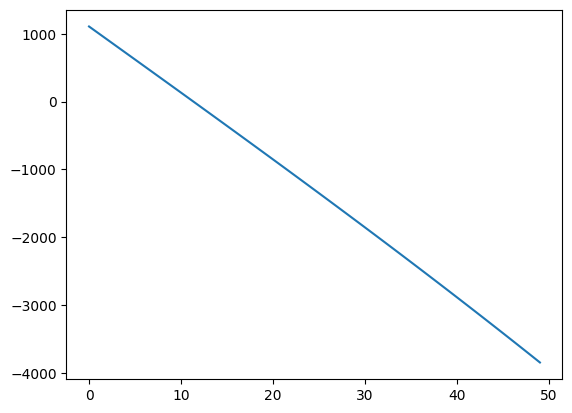

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.show()